In [1]:
!nvidia-smi

Tue Apr  9 12:19:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install super-gradients
!pip install -qq git+https://github.com/ytdl-org/youtube-dl.git
!pip install -qq gdown torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 818.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.

  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user


In [3]:

import json
import os
import random
from pathlib import Path
from typing import Any, List, Tuple, Union

# Third-party imports
import cv2
import gdown
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from IPython.display import YouTubeVideo
from sklearn.model_selection import train_test_split

# Colab specific imports
from google.colab.patches import cv2_imshow

# Constants
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 🪡 Fine-tuning YOLO-NAS-Pose

## 🏋🏽 The trainer

The first thing you need to define in SuperGradients is the Trainer.

The trainer is in charge of training, evaluation, saving checkpoints, etc. If you're interested in seeing the source code for the trainer, you can do so [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/sg_trainer/sg_trainer.py).

### ✌🏼 There's two important arguments to the trainer:

1) `ckpt_root_dir` - this is the directory where results from all your experiments will be saved

2)`experiment_name` - all checkpoints, logs, and tensorboards will be saved in a directory with the name you specify here.

In [17]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='first_yn_pose_run', ckpt_root_dir=CHECKPOINT_DIR)

# ⤵️ Download Pose Estimation Dataset


In [37]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ArGAbA8yDjYOUv1YqQWf")
project = rf.workspace("baa-8sopl").project("key-point-detection-72mgr")
version = project.version(1)
dataset = version.download("coco")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.23.0 which is incompatible.
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Key-Point-Detection-3-4 in coco:: 100%|██████████| 80/80 [00:00<00:00, 8127.31it/s]


In [1]:
# @title
!wget https://raw.githubusercontent.com/Deci-AI/super-gradients/master/src/super_gradients/recipes/dataset_params/coco_pose_estimation_common_dataset_params.yaml

--2024-04-09 12:30:00--  https://raw.githubusercontent.com/Deci-AI/super-gradients/master/src/super_gradients/recipes/dataset_params/coco_pose_estimation_common_dataset_params.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1937 (1.9K) [text/plain]
Saving to: ‘coco_pose_estimation_common_dataset_params.yaml’

coco_pose_estimatio 100%[===================>]   1.89K  --.-KB/s    in 0s      

2024-04-09 12:30:00 (33.9 MB/s) - ‘coco_pose_estimation_common_dataset_params.yaml’ saved [1937/1937]



In [19]:
# @title
def open_file(file_path: str) -> Union[dict, list, None]:
    """
    Opens and reads the content of a JSON or YAML file.

    Parameters:
    file_path (str): The path to the file.

    Returns:
    Union[dict, list, None]: The content of the file parsed to a dictionary or a list,
                             or None if an error occurs.
    """
    try:
        with open(file_path, 'r') as file:
            if file_path.endswith('.json'):
                return json.load(file)
            elif file_path.endswith('.yaml') or file_path.endswith('.yml'):
                return yaml.safe_load(file)
            else:
                raise ValueError(f'Unsupported file format: {file_path}')
    except Exception as e:
        print(f'An error occurred: {e}')
        return None

# Usage:
annotations = open_file('/content/Key-Point-Detection-3-4/train/_annotations.coco.json')
config = open_file('/content/coco_pose_estimation_common_dataset_params.yaml')

# Annotation File Breakdown

Each image is annotated with keypoints indicating specific parts of the animal, and these keypoints are categorized under different animal categories. The dataset also provides a skeleton structure, indicating how the keypoints are connected for each animal category.

### The dictionary has the following keys and values:

### 1. **images**:
   - It's a dictionary where each entry maps an ID to a filename (typically an image filename). Each image in the dataset has a unique identifier, and this is a lookup between the ID and the filename.

### 2. **annotations**:
   - This is a list containing 6,117 items. Each item is a dictionary with details related to the annotations for a particular image.
   - Each annotation contains an `image_id`, a list of `keypoints`, and `num_keypoints` value.

### 3. **categories**:
   - A list of categories for the dataset.
   - Each category has a:
     - `supercategory`: A broader classification (like 'animal').
     - `id`: A unique identifier for the category.
     - `name`: The name of the category (e.g., 'dog', 'cat', 'sheep').
     - `keypoints`: A list of names for specific keypoints relevant to that category (like 'left_eye', 'right_eye', 'nose', etc.).
     - `skeleton`: A list of pairs, which are connections between keypoints.



In [5]:
# @title Plotting a sample of images

def plot_random_images(data, image_base_dir="/content/images"):
    """
    Plots 5 random images for each category from the provided dataset.

    Parameters:
    - data: The JSON dataset containing image, annotation, and category details.
    - image_base_dir: The base directory where the images are located.
    """

    # Create a dictionary to map image IDs to filenames
    print(data)
    image_id_to_filename = {image['id']: image['file_name'] for image in data['images']}

    # Extracting image_ids for each category
    category_image_ids = {}
    for category in data['categories']:
        category_id = category['id']
        category_name = category['name']
        category_image_ids[category_name] = [anno['image_id'] for anno in data['annotations'] if anno['category_id'] == category_id]

    # Randomly select 5 image_ids for each category
    random_selected_ids = {}
    for category_name, ids in category_image_ids.items():
        random_selected_ids[category_name] = random.sample(ids, min(5, len(ids)))

    # Number of categories
    num_categories = len(random_selected_ids)

    # Create a figure to plot the images
    fig, axes = plt.subplots(num_categories, 5, figsize=(20, num_categories * 3))
    if num_categories == 1:  # If there is only one category, axes will be 1D
        axes = [axes]

    for i, (category_name, ids) in enumerate(random_selected_ids.items()):
        for j, image_id in enumerate(ids):
            # Get the filename using the image_id_to_filename dictionary
            filename = image_id_to_filename.get(image_id, "Image_Not_Found.jpg")

            # Load and plot the image
            img_path = os.path.join(image_base_dir, filename)
            try:
                img = mpimg.imread(img_path)
                axes[i][j].imshow(img)
            except FileNotFoundError:
                axes[i][j].imshow(np.zeros((100, 100, 3)))  # Show an empty image if file is not found
            axes[i][j].axis('off')
            if j == 0:
                axes[i][j].set_title(category_name)

    plt.tight_layout()
    plt.show()

{'info': {'year': '2024', 'version': '4', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2024-04-09T08:03:42+00:00'}, 'licenses': [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}], 'categories': [{'id': 0, 'name': 'zahn', 'supercategory': 'none'}, {'id': 1, 'name': 'zahn', 'supercategory': 'zahn', 'keypoints': ['a', 'b', 'c', 'd'], 'skeleton': [[1, 2], [2, 3], [3, 4], [4, 1]]}], 'images': [{'id': 0, 'license': 1, 'file_name': 'zahn_66_png.rf.31ab5ec36d38807c5ac1a4d0cecc28fd.jpg', 'height': 640, 'width': 640, 'date_captured': '2024-04-09T08:03:42+00:00'}, {'id': 1, 'license': 1, 'file_name': 'zahn_47_png.rf.52cde8f3da17161a22a0381e182f880d.jpg', 'height': 640, 'width': 640, 'date_captured': '2024-04-09T08:03:42+00:00'}, {'id': 2, 'license': 1, 'file_name': 'zahn_43_png.rf.298533787f8730c3cdf78976bea20748.jpg', 'height': 640, 'width': 640, 'date_capture

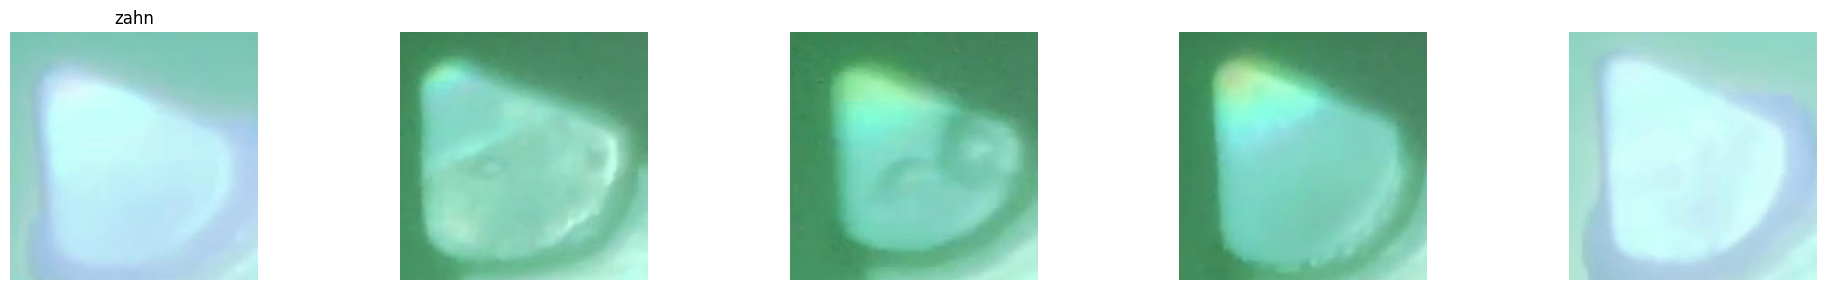

In [6]:
plot_random_images(data=annotations, image_base_dir="/content/Key-Point-Detection-3-4/train")

# 💾 Datasets and DataLoaders

SuperGradients is fully compatible with PyTorch Datasets and Dataloaders, so you can use your dataloaders as is.

### SuperGradients also provides you with the `AbstractPoseEstimationDataset` class.

This is an abstract class defines a blueprint for datasets related to pose estimation tasks. It's expected that concrete implementations of this class will be created for specific datasets.

- **Inheritance**: It inherits from PyTorch's `Dataset` and `HasPreprocessingParams`.

- **Initialization**:
  - Takes in parameters like `transforms`, `num_joints`, `edge_links`, `edge_colors`, and `keypoint_colors`.
  - Initializes instance variables and constructs a transform pipeline (`KeypointsCompose`).

- **Abstract Methods (`__len__` and `load_sample`)**:
  - These methods are declared but don't have a concrete implementation in this class. Your derived class from this abstract class is expected to provide an implementation for these methods.
  
- **`load_random_sample` Method**:
  - This method is used to fetch a random sample from the dataset. It uses the `__len__` method to get the total number of samples and then randomly selects an index to retrieve using `load_sample`.

- **`__getitem__` Method**:
  - This method retrieves a sample given its index. It then applies the defined transformations on the sample and returns it. This method is crucial for PyTorch's DataLoader to fetch samples during training.

- **`get_dataset_preprocessing_params` Method**:
  - This method defines and returns preprocessing parameters for the dataset. It seems to construct a pipeline of preprocessing steps and their parameters.


In [7]:
# @title Expand this cell to see how the `AnimalPoseEstimationDataset` is implemented
from super_gradients.common.decorators.factory_decorator import resolve_param
from super_gradients.common.factories.target_generator_factory import TargetGeneratorsFactory
from super_gradients.common.factories.transforms_factory import TransformsFactory
from super_gradients.common.object_names import Datasets
from super_gradients.common.registry import register_dataset
from super_gradients.training.transforms.keypoint_transforms import AbstractKeypointTransform
from super_gradients.training.samples import PoseEstimationSample

from super_gradients.training.datasets.pose_estimation_datasets.abstract_pose_estimation_dataset import AbstractPoseEstimationDataset

from super_gradients.training.datasets.pose_estimation_datasets import YoloNASPoseCollateFN

class PoseEstimationDataset(AbstractPoseEstimationDataset):
    """
    Dataset class for training pose estimation models on Animal Pose dataset.
    """


    @resolve_param("transforms", TransformsFactory())
    def __init__(
        self,
        data_dir: str,
        images_dir: str,
        json_file: str,
        transforms: List[AbstractKeypointTransform],
        edge_links: Union[List[Tuple[int, int]], np.ndarray],
        edge_colors: Union[List[Tuple[int, int, int]], np.ndarray, None],
        keypoint_colors: Union[List[Tuple[int, int, int]], np.ndarray, None],
    ):
        """

        :param data_dir: Root directory of the COCO dataset
        :param images_dir: path suffix to the images directory inside the data_dir
        :param json_file: path suffix to the json file inside the data_dir
        :param include_empty_samples: Not used, but exists for compatibility with COCO dataset config.
        :param target_generator: Target generator that will be used to generate the targets for the model.
            See DEKRTargetsGenerator for an example.
        :param transforms: Transforms to be applied to the image & keypoints
        """
        split_json_file = os.path.join(data_dir, json_file)

        with open(split_json_file, "r") as f:
            json_annotations = json.load(f)


        joints = json_annotations["categories"][1]["keypoints"]
        num_joints = len(joints)

        super().__init__(
            transforms=transforms,
            num_joints=num_joints,
            edge_links=edge_links,
            edge_colors=edge_colors,
            keypoint_colors=keypoint_colors,
        )

        self.num_joints = num_joints
        print('h',self.num_joints)


        images_and_ids = []

        for image in json_annotations["images"]:
          images_and_ids.append((image["id"], os.path.join(data_dir, images_dir, image["file_name"])))
        self.image_ids, self.image_files = zip(*images_and_ids)

        self.annotations = []

        for image_id in self.image_ids:
            keypoints_per_image = []
            bboxes_per_image = []

            image_annotations = [ann for ann in json_annotations["annotations"] if str(ann["image_id"]) == str(image_id)]
            for ann in image_annotations:
                keypoints = np.array(ann["keypoints"]).reshape(self.num_joints, 3)
                x1, y1, x2, y2 = ann["bbox"]

                bbox_xywh = np.array([x1, y1, x2 - x1, y2 - y1])
                keypoints_per_image.append(keypoints)
                bboxes_per_image.append(bbox_xywh)

            keypoints_per_image = np.array(keypoints_per_image, dtype=np.float32).reshape(-1, self.num_joints, 3)
            bboxes_per_image = np.array(bboxes_per_image, dtype=np.float32).reshape(-1, 4)
            annotation = keypoints_per_image, bboxes_per_image
            self.annotations.append(annotation)

    def __len__(self):
        return len(self.image_ids)

    def load_sample(self, index) -> PoseEstimationSample:
        file_path = self.image_files[index]
        gt_joints, gt_bboxes = self.annotations[index]  # boxes in xywh format

        gt_areas = np.array([box[2] * box[3] for box in gt_bboxes], dtype=np.float32)
        gt_iscrowd = np.array([0] * len(gt_joints), dtype=bool)

        image = cv2.imread(file_path, cv2.IMREAD_COLOR)
        mask = np.ones(image.shape[:2], dtype=np.float32)

        return PoseEstimationSample(
            image=image, mask=mask, joints=gt_joints, areas=gt_areas, bboxes_xywh=gt_bboxes, is_crowd=gt_iscrowd, additional_samples=None
        )

[2024-04-09 12:32:24] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-04-09 12:32:29] INFO - utils.py - NumExpr defaulting to 2 threads.


In [20]:

train_annotations = open_file('/content/Key-Point-Detection-3-4/train/_annotations.coco.json')
val_annotations = open_file('/content/Key-Point-Detection-3-4/valid/_annotations.coco.json')
test_annotations = open_file('/content/Key-Point-Detection-3-4/test/_annotations.coco.json')

# KeyPoint Transformations

SuperGradients has a number of transformations for KeyPoints. Take a look at the [source code](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/transforms/keypoints) to see them all and get more detail.

All the the transforms subclass from the [`AbstractKeypointTransform`](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/transforms/keypoints/abstract_keypoints_transform.py) class.




In [9]:
# @title Expand this cell to see how the transforms are instantiated
from super_gradients.training.transforms.keypoints import (
    KeypointsHSV,
    KeypointsBrightnessContrast,
    KeypointsMosaic,
    KeypointsRandomAffineTransform,
    KeypointsLongestMaxSize,
    KeypointsPadIfNeeded,
    KeypointsImageStandardize,
    KeypointsImageNormalize,
    KeypointsRemoveSmallObjects
)

# Indexes of keypoints on the flipped image. When doing left-right flip, left hand becomes right hand.
#So this array contains order of keypoints on the flipped image. This is dataset specific and depends on
#how keypoints are defined in dataset.
#keypoints_random_horizontal_flip = KeypointsRandomHorizontalFlip(flip_index=config['flip_indexes'], prob=0.5)

keypoints_hsv = KeypointsHSV(prob=0.5, hgain=20, sgain=20, vgain=20)

keypoints_brightness_contrast = KeypointsBrightnessContrast(prob=0.5,
                                                            brightness_range=[0.8, 1.2],
                                                            contrast_range=[0.8, 1.2]
                                                            )

keypoints_mosaic = KeypointsMosaic(prob=0.8)

keypoints_random_affine_transform = KeypointsRandomAffineTransform(max_rotation=0,
                                                                   min_scale=0.5,
                                                                   max_scale=1.5,
                                                                   max_translate=0.1,
                                                                   image_pad_value=127,
                                                                   mask_pad_value=1,
                                                                   prob=0.75,
                                                                   interpolation_mode=[0, 1, 2, 3, 4]
                                                                   )

keypoints_longest_max_size = KeypointsLongestMaxSize(max_height=640, max_width=640)

keypoints_pad_if_needed = KeypointsPadIfNeeded(min_height=640,
                                               min_width=640,
                                               image_pad_value=[127, 127, 127],
                                               mask_pad_value=1,
                                               padding_mode='bottom_right'
                                               )

keypoints_image_standardize = KeypointsImageStandardize(max_value=255)

# keypoints_image_normalize = KeypointsImageNormalize(mean=[0.485, 0.456, 0.406],
#                                                     std=[0.229, 0.224, 0.225]
#                                                     )

keypoints_remove_small_objects = KeypointsRemoveSmallObjects(min_instance_area=1,
                                                             min_visible_keypoints=1
                                                             )


### Arguments for `AnimalPoseEstimationDataset`:

The `AnimalPoseEstimationDataset` is being initialized with paths to the data, a list of transformations, and visualization-specific parameters like edge links and colors.


1. **`data_dir`**: Specifies the base directory where the dataset is located.

2. **`images_dir`**: Specifies the sub-directory (relative to `data_dir`) where the images of the dataset are stored.

3. **`json_file`**: Path to the JSON file that contains the annotations for the images.

4. **`transforms`**: A list of transformations (or data augmentations) to apply to the images and their associated keypoints during training. These are detched from the configuration file downloaded earlier. It's instantiated as a dictionary (`config`) with key `'train_dataset_params'` and then further extracting the `'transforms'` key.

5. **`edge_links`**: Specifies the links (or connections) between keypoints. It's a list of pairs where each pair represents a connection between two keypoints. Fetched from the `config` dictionary using the key `'edge_links'`.

6. **`edge_colors`**: Colors for the edge links defined above. Fetched from the `config` dictionary using the key `'edge_colors'`.

7. **`keypoint_colors`**: Specifies the colors for individual keypoints. Fetched from the `config` dictionary using the key `'keypoint_colors'`.




In [21]:
train_transforms = [
    keypoints_image_standardize
]

val_transforms = [
    keypoints_image_standardize
]

In [22]:
data_path = "/content/Key-Point-Detection-3-4"


# Create instances of the dataset
train_dataset = PoseEstimationDataset(
    data_dir=data_path,
    images_dir= data_path + '/train',
    json_file= data_path + '/train/_annotations.coco.json',
    transforms=train_transforms,
    edge_links = config['edge_links'],
    edge_colors = config['edge_colors'],
    keypoint_colors = config['keypoint_colors']
    )

val_dataset = PoseEstimationDataset(
    data_dir=data_path,
    images_dir= data_path + '/valid',
    json_file= data_path + '/valid/_annotations.coco.json',
    transforms=val_transforms,
    edge_links = config['edge_links'],
    edge_colors = config['edge_colors'],
    keypoint_colors = config['keypoint_colors']
    )

test_dataset = PoseEstimationDataset(
    data_dir=data_path,
    images_dir= data_path + '/test',
    json_file= data_path + '/test/_annotations.coco.json',
    transforms=val_transforms,
    edge_links = config['edge_links'],
    edge_colors = config['edge_colors'],
    keypoint_colors = config['keypoint_colors']
    )

h 4
h 4
h 4


You can also pass PyTorch DataLoaders arguments when instantiating your DataLoadeer.


In [23]:
from torch.utils.data import DataLoader

# Create dataloaders
train_dataloader_params = {
    'shuffle': True,
    'batch_size': 8,
    'drop_last': True,
    'pin_memory': False,
    'collate_fn': YoloNASPoseCollateFN()
    }

val_dataloader_params = {
    'shuffle': True,
    'batch_size': 8,
    'drop_last': True,
    'pin_memory': False,
    'collate_fn': YoloNASPoseCollateFN()
    }
val_dataloader = DataLoader(val_dataset, **val_dataloader_params)
print(len(val_dataloader))

print(len(val_dataloader.dataset))



train_dataloader = DataLoader(train_dataset, **train_dataloader_params)
print(len(train_dataloader))




test_dataloader = DataLoader(test_dataset, **val_dataloader_params)

# 👩🏽‍🦳 Instantiating the model

You saw how to instantiate the model for inference earlier.

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial you're using `yolo_nas_l`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_s` and `yolo_nas_m`.

In [13]:
print(config['num_joints'])
from super_gradients.training import models
from super_gradients.common.object_names import Models
yolo_nas_pose = models.get("yolo_nas_pose_l",
                           num_classes=config['num_joints'],
                           pretrained_weights="coco_pose")

4


[2024-04-09 12:34:05] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco_pose dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-04-09 12:34:05] INFO - checkpoint_utils.py - License Notification: YOLO-NAS-POSE pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS-POSE.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_pose_l_coco_pose.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_pose_l_coco_pose.pth
100%|██████████| 304M/304M [00:04<00:00, 74.4MB/s]
[20

# 🎛️ Training parameters

You need to define the training parameters for your training run.

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


We'll use the same traning parameters that were used to pre-train the model on COCO Pose. You can see them [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/coco2017_yolo_nas_pose_train_params.yaml)

### 🚨 There are a few **mandatory** arguments that you must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`.

### 🪄 SuperGradients offers a number of training tricks right out of the box, such as:

- Exponential moving average
- Zero weight decay on bias and batch normalizatiom
- Weight averaging
- Batch accumulation
- Precise BatchNorm

You can read more details about these training tricks [here](https://heartbeat.comet.ml/a-better-way-to-train-your-neural-networks-813b60a5bd6a).

If you're interested in building a using a custom metric with SuperGradients you can learn how [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Metrics.md).

You probably noticed that we make use of a post prediction callback, for details on how phase callbacks work in SuperGradients [check out our documentation](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/PhaseCallbacks.md).

### 🔕 Note: I've enabled `silent_mode` so the notebook doesn't get longer than it already is. You should disable it so you can see what SuperGradients outputs during training.

In [24]:
# @title Expand this cell to see the training params
from super_gradients.training.models.pose_estimation_models.yolo_nas_pose import YoloNASPosePostPredictionCallback
from super_gradients.training.utils.callbacks import ExtremeBatchPoseEstimationVisualizationCallback, Phase
from super_gradients.training.utils.early_stopping import EarlyStop
from super_gradients.training.metrics import PoseEstimationMetrics

# Note: after next release unwrap all lines wrapped in oc.OmegaConf.create
import omegaconf as oc

post_prediction_callback = YoloNASPosePostPredictionCallback(
  pose_confidence_threshold = 0.01,
  nms_iou_threshold = 0.7,
  pre_nms_max_predictions = 300,
  post_nms_max_predictions = 30,
)

metrics = PoseEstimationMetrics(
  num_joints = config['num_joints'],
  oks_sigmas = config['oks_sigmas'],
  max_objects_per_image = 30,
  post_prediction_callback = post_prediction_callback,
)

visualization_callback = ExtremeBatchPoseEstimationVisualizationCallback(
  keypoint_colors = config["keypoint_colors"],
  edge_colors = config['edge_colors'],
  edge_links = config['edge_links'],
  loss_to_monitor = "YoloNASPoseLoss/loss",
  max = True,
  freq = 1,
  max_images = 1,
  enable_on_train_loader = True,
  enable_on_valid_loader = True,
  post_prediction_callback = post_prediction_callback,
)

early_stop = EarlyStop(
  phase = Phase.VALIDATION_EPOCH_END,
  monitor = "AP",
  mode = "max",
  min_delta = 0.0001,
  patience = 30,
  verbose = True,
)

train_params = {
    "warmup_mode": "LinearBatchLRWarmup",
    "warmup_initial_lr": 1e-8,
    "lr_warmup_epochs": 1,
    "initial_lr": 5e-5,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 5e-3,
    "max_epochs": 60,
    "zero_weight_decay_on_bias_and_bn": True,
    "batch_accumulate": 1,
    "average_best_models": True,
    "save_ckpt_epoch_list": [5, 10, 15, 20, 30, 40, 50, 60, 80, 100, 120, 150],
    "loss": "yolo_nas_pose_loss",
    "criterion_params": {
        "oks_sigmas": config['oks_sigmas'],
        "classification_loss_weight": 1.0,
        "classification_loss_type": "focal",
        "regression_iou_loss_type": "ciou",
        "iou_loss_weight": 2.5,
        "dfl_loss_weight": 0.01,
        "pose_cls_loss_weight": 1.0,
        "pose_reg_loss_weight": 34.0,
        "pose_classification_loss_type": "focal",
        "rescale_pose_loss_with_assigned_score": True,
        "assigner_multiply_by_pose_oks": True,
    },
    "optimizer": "AdamW",
    "optimizer_params": {
        "weight_decay": 0.000001
    },
    "ema": True,
    "ema_params": {
        "decay": 0.997,
        "decay_type": "threshold"
    },
    "mixed_precision": True,
    "sync_bn": False,
    "valid_metrics_list": [metrics],
    "phase_callbacks": [visualization_callback, early_stop],
    "pre_prediction_callback": None,
    "metric_to_watch": "AP",
    "greater_metric_to_watch_is_better": True,
    "_convert_": "all"
}

# 🦾 Training the model

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters


### ⏳ Now, its time to train a model

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as...

In [25]:
print(val_dataloader.dataset.image_ids)
# Note, this is training for 10 epochs to demonstrate how to do it
trainer.train(model=yolo_nas_pose,
              training_params=train_params,
              train_loader=train_dataloader,
              valid_loader=val_dataloader
              )

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)
The console stream is now moved to checkpoints/first_yn_pose_run/RUN_20240409_123803_683812/console_Apr09_12_38_03.txt


[2024-04-09 12:38:03] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240409_123803_683812`
[2024-04-09 12:38:03] INFO - sg_trainer.py - Checkpoints directory: checkpoints/first_yn_pose_run/RUN_20240409_123803_683812
[2024-04-09 12:38:03] INFO - sg_trainer.py - Using EMA with params {'decay': 0.997, 'decay_type': 'threshold'}
[2024-04-09 12:38:04] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            49         (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         6          (len(train_loader))
    - Gradient updates per epoch:   6         

SUMMARY OF EPOCH 0
├── Train
│   ├── Yolonasposeloss/loss_cls = 1238.943
│   ├── Yolonasposeloss/loss_iou = 1.2103
│   ├── Yolonasposeloss/loss_dfl = 0.0489
│   ├── Yolonasposeloss/loss_pose_cls = 0.7053
│   ├── Yolonasposeloss/loss_pose_reg = 26.8493
│   └── Yolonasposeloss/loss = 1267.7566
└── Validation
    ├── Yolonasposeloss/loss_cls = 449.1443
    ├── Yolonasposeloss/loss_iou = 0.6833
    ├── Yolonasposeloss/loss_dfl = 0.0365
    ├── Yolonasposeloss/loss_pose_cls = 0.822
    ├── Yolonasposeloss/loss_pose_reg = 26.1761
    ├── Yolonasposeloss/loss = 476.8623
    ├── Ap = 0.0
    └── Ar = 0.0



Validating epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
[2024-04-09 12:38:26] INFO - early_stopping.py - Monitored metric AP did not improve in the last 1 records.


SUMMARY OF EPOCH 1
├── Train
│   ├── Yolonasposeloss/loss_cls = 1132.607
│   │   ├── Epoch N-1      = 1238.943 (↘ -106.3359)
│   │   └── Best until now = 1238.943 (↘ -106.3359)
│   ├── Yolonasposeloss/loss_iou = 1.1963
│   │   ├── Epoch N-1      = 1.2103 (↘ -0.014)
│   │   └── Best until now = 1.2103 (↘ -0.014)
│   ├── Yolonasposeloss/loss_dfl = 0.0481
│   │   ├── Epoch N-1      = 0.0489 (↘ -0.0008)
│   │   └── Best until now = 0.0489 (↘ -0.0008)
│   ├── Yolonasposeloss/loss_pose_cls = 0.7204
│   │   ├── Epoch N-1      = 0.7053 (↗ 0.0151)
│   │   └── Best until now = 0.7053 (↗ 0.0151)
│   ├── Yolonasposeloss/loss_pose_reg = 26.8566
│   │   ├── Epoch N-1      = 26.8493 (↗ 0.0073)
│   │   └── Best until now = 26.8493 (↗ 0.0073)
│   └── Yolonasposeloss/loss = 1161.4285
│       ├── Epoch N-1      = 1267.7566 (↘ -106.3281)
│       └── Best until now = 1267.7566 (↘ -106.3281)
└── Validation
    ├── Yolonasposeloss/loss_cls = 356.1812
    │   ├── Epoch N-1      = 449.1443 (↘ -92.963)
    │   

Validating epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
[2024-04-09 12:38:46] INFO - early_stopping.py - Monitored metric AP did not improve in the last 2 records.


SUMMARY OF EPOCH 2
├── Train
│   ├── Yolonasposeloss/loss_cls = 990.4279
│   │   ├── Epoch N-1      = 1132.607 (↘ -142.1792)
│   │   └── Best until now = 1132.607 (↘ -142.1792)
│   ├── Yolonasposeloss/loss_iou = 1.2564
│   │   ├── Epoch N-1      = 1.1963 (↗ 0.0601)
│   │   └── Best until now = 1.1963 (↗ 0.0601)
│   ├── Yolonasposeloss/loss_dfl = 0.049
│   │   ├── Epoch N-1      = 0.0481 (↗ 0.0009)
│   │   └── Best until now = 0.0481 (↗ 0.0009)
│   ├── Yolonasposeloss/loss_pose_cls = 0.7185
│   │   ├── Epoch N-1      = 0.7204 (↘ -0.0019)
│   │   └── Best until now = 0.7053 (↗ 0.0133)
│   ├── Yolonasposeloss/loss_pose_reg = 26.7841
│   │   ├── Epoch N-1      = 26.8566 (↘ -0.0726)
│   │   └── Best until now = 26.8493 (↘ -0.0653)
│   └── Yolonasposeloss/loss = 1019.2358
│       ├── Epoch N-1      = 1161.4285 (↘ -142.1926)
│       └── Best until now = 1161.4285 (↘ -142.1926)
└── Validation
    ├── Yolonasposeloss/loss_cls = 255.9118
    │   ├── Epoch N-1      = 356.1812 (↘ -100.2694)
    │ 

Validating epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
[2024-04-09 12:39:03] INFO - early_stopping.py - Monitored metric AP did not improve in the last 3 records.


SUMMARY OF EPOCH 3
├── Train
│   ├── Yolonasposeloss/loss_cls = 178.026
│   │   ├── Epoch N-1      = 990.4279 (↘ -812.4018)
│   │   └── Best until now = 990.4279 (↘ -812.4018)
│   ├── Yolonasposeloss/loss_iou = 1.1932
│   │   ├── Epoch N-1      = 1.2564 (↘ -0.0632)
│   │   └── Best until now = 1.1963 (↘ -0.0031)
│   ├── Yolonasposeloss/loss_dfl = 0.0487
│   │   ├── Epoch N-1      = 0.049  (↘ -0.0003)
│   │   └── Best until now = 0.0481 (↗ 0.0006)
│   ├── Yolonasposeloss/loss_pose_cls = 0.6895
│   │   ├── Epoch N-1      = 0.7185 (↘ -0.0291)
│   │   └── Best until now = 0.7053 (↘ -0.0158)
│   ├── Yolonasposeloss/loss_pose_reg = 26.7625
│   │   ├── Epoch N-1      = 26.7841 (↘ -0.0215)
│   │   └── Best until now = 26.7841 (↘ -0.0215)
│   └── Yolonasposeloss/loss = 206.7199
│       ├── Epoch N-1      = 1019.2358 (↘ -812.516)
│       └── Best until now = 1019.2358 (↘ -812.516)
└── Validation
    ├── Yolonasposeloss/loss_cls = 28.1926
    │   ├── Epoch N-1      = 255.9118 (↘ -227.7192)
    │ 

Validating epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
[2024-04-09 12:39:26] INFO - early_stopping.py - Monitored metric AP did not improve in the last 4 records.


SUMMARY OF EPOCH 4
├── Train
│   ├── Yolonasposeloss/loss_cls = 30.8394
│   │   ├── Epoch N-1      = 178.026 (↘ -147.1866)
│   │   └── Best until now = 178.026 (↘ -147.1866)
│   ├── Yolonasposeloss/loss_iou = 1.2105
│   │   ├── Epoch N-1      = 1.1932 (↗ 0.0173)
│   │   └── Best until now = 1.1932 (↗ 0.0173)
│   ├── Yolonasposeloss/loss_dfl = 0.0468
│   │   ├── Epoch N-1      = 0.0487 (↘ -0.0019)
│   │   └── Best until now = 0.0481 (↘ -0.0013)
│   ├── Yolonasposeloss/loss_pose_cls = 0.6823
│   │   ├── Epoch N-1      = 0.6895 (↘ -0.0072)
│   │   └── Best until now = 0.6895 (↘ -0.0072)
│   ├── Yolonasposeloss/loss_pose_reg = 26.6035
│   │   ├── Epoch N-1      = 26.7625 (↘ -0.159)
│   │   └── Best until now = 26.7625 (↘ -0.159)
│   └── Yolonasposeloss/loss = 59.3824
│       ├── Epoch N-1      = 206.7199 (↘ -147.3374)
│       └── Best until now = 206.7199 (↘ -147.3374)
└── Validation
    ├── Yolonasposeloss/loss_cls = 5.209
    │   ├── Epoch N-1      = 28.1926 (↘ -22.9836)
    │   └── Best

Validating epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
[2024-04-09 12:40:03] INFO - early_stopping.py - Monitored metric AP did not improve in the last 5 records.


SUMMARY OF EPOCH 5
├── Train
│   ├── Yolonasposeloss/loss_cls = 12.6966
│   │   ├── Epoch N-1      = 30.8394 (↘ -18.1428)
│   │   └── Best until now = 30.8394 (↘ -18.1428)
│   ├── Yolonasposeloss/loss_iou = 1.0725
│   │   ├── Epoch N-1      = 1.2105 (↘ -0.1379)
│   │   └── Best until now = 1.1932 (↘ -0.1206)
│   ├── Yolonasposeloss/loss_dfl = 0.044
│   │   ├── Epoch N-1      = 0.0468 (↘ -0.0027)
│   │   └── Best until now = 0.0468 (↘ -0.0027)
│   ├── Yolonasposeloss/loss_pose_cls = 0.6701
│   │   ├── Epoch N-1      = 0.6823 (↘ -0.0122)
│   │   └── Best until now = 0.6823 (↘ -0.0122)
│   ├── Yolonasposeloss/loss_pose_reg = 26.6652
│   │   ├── Epoch N-1      = 26.6035 (↗ 0.0617)
│   │   └── Best until now = 26.6035 (↗ 0.0617)
│   └── Yolonasposeloss/loss = 41.1484
│       ├── Epoch N-1      = 59.3824 (↘ -18.234)
│       └── Best until now = 59.3824 (↘ -18.234)
└── Validation
    ├── Yolonasposeloss/loss_cls = 2.7064
    │   ├── Epoch N-1      = 5.209  (↘ -2.5026)
    │   └── Best until n

Validating epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
[2024-04-09 12:40:25] INFO - early_stopping.py - Monitored metric AP did not improve in the last 6 records.


SUMMARY OF EPOCH 6
├── Train
│   ├── Yolonasposeloss/loss_cls = 7.6436
│   │   ├── Epoch N-1      = 12.6966 (↘ -5.053)
│   │   └── Best until now = 12.6966 (↘ -5.053)
│   ├── Yolonasposeloss/loss_iou = 1.0797
│   │   ├── Epoch N-1      = 1.0725 (↗ 0.0072)
│   │   └── Best until now = 1.0725 (↗ 0.0072)
│   ├── Yolonasposeloss/loss_dfl = 0.0431
│   │   ├── Epoch N-1      = 0.044  (↘ -0.001)
│   │   └── Best until now = 0.044  (↘ -0.001)
│   ├── Yolonasposeloss/loss_pose_cls = 0.6605
│   │   ├── Epoch N-1      = 0.6701 (↘ -0.0095)
│   │   └── Best until now = 0.6701 (↘ -0.0095)
│   ├── Yolonasposeloss/loss_pose_reg = 26.5142
│   │   ├── Epoch N-1      = 26.6652 (↘ -0.151)
│   │   └── Best until now = 26.6035 (↘ -0.0893)
│   └── Yolonasposeloss/loss = 35.9411
│       ├── Epoch N-1      = 41.1484 (↘ -5.2073)
│       └── Best until now = 41.1484 (↘ -5.2073)
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.4157
    │   ├── Epoch N-1      = 2.7064 (↘ -1.2907)
    │   └── Best until now = 2.

Validating epoch 7: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
[2024-04-09 12:40:56] INFO - early_stopping.py - Monitored metric AP did not improve in the last 7 records.


SUMMARY OF EPOCH 7
├── Train
│   ├── Yolonasposeloss/loss_cls = 5.9323
│   │   ├── Epoch N-1      = 7.6436 (↘ -1.7114)
│   │   └── Best until now = 7.6436 (↘ -1.7114)
│   ├── Yolonasposeloss/loss_iou = 1.0484
│   │   ├── Epoch N-1      = 1.0797 (↘ -0.0313)
│   │   └── Best until now = 1.0725 (↘ -0.0241)
│   ├── Yolonasposeloss/loss_dfl = 0.0457
│   │   ├── Epoch N-1      = 0.0431 (↗ 0.0027)
│   │   └── Best until now = 0.0431 (↗ 0.0027)
│   ├── Yolonasposeloss/loss_pose_cls = 0.6151
│   │   ├── Epoch N-1      = 0.6605 (↘ -0.0455)
│   │   └── Best until now = 0.6605 (↘ -0.0455)
│   ├── Yolonasposeloss/loss_pose_reg = 26.4531
│   │   ├── Epoch N-1      = 26.5142 (↘ -0.061)
│   │   └── Best until now = 26.5142 (↘ -0.061)
│   └── Yolonasposeloss/loss = 34.0946
│       ├── Epoch N-1      = 35.9411 (↘ -1.8465)
│       └── Best until now = 35.9411 (↘ -1.8465)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.6165
    │   ├── Epoch N-1      = 1.4157 (↘ -0.7992)
    │   └── Best until now = 1

Validating epoch 8: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
[2024-04-09 12:41:29] INFO - early_stopping.py - Monitored metric AP did not improve in the last 8 records.


SUMMARY OF EPOCH 8
├── Train
│   ├── Yolonasposeloss/loss_cls = 5.0661
│   │   ├── Epoch N-1      = 5.9323 (↘ -0.8662)
│   │   └── Best until now = 5.9323 (↘ -0.8662)
│   ├── Yolonasposeloss/loss_iou = 1.0685
│   │   ├── Epoch N-1      = 1.0484 (↗ 0.0201)
│   │   └── Best until now = 1.0484 (↗ 0.0201)
│   ├── Yolonasposeloss/loss_dfl = 0.0433
│   │   ├── Epoch N-1      = 0.0457 (↘ -0.0025)
│   │   └── Best until now = 0.0431 (↗ 0.0002)
│   ├── Yolonasposeloss/loss_pose_cls = 0.6231
│   │   ├── Epoch N-1      = 0.6151 (↗ 0.0081)
│   │   └── Best until now = 0.6151 (↗ 0.0081)
│   ├── Yolonasposeloss/loss_pose_reg = 26.3931
│   │   ├── Epoch N-1      = 26.4531 (↘ -0.0601)
│   │   └── Best until now = 26.4531 (↘ -0.0601)
│   └── Yolonasposeloss/loss = 33.194
│       ├── Epoch N-1      = 34.0946 (↘ -0.9006)
│       └── Best until now = 34.0946 (↘ -0.9006)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.8572
    │   ├── Epoch N-1      = 0.6165 (↗ 0.2407)
    │   └── Best until now = 0.61

Validating epoch 9: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
[2024-04-09 12:42:35] INFO - early_stopping.py - Monitored metric AP did not improve in the last 9 records.


SUMMARY OF EPOCH 9
├── Train
│   ├── Yolonasposeloss/loss_cls = 3.5709
│   │   ├── Epoch N-1      = 5.0661 (↘ -1.4951)
│   │   └── Best until now = 5.0661 (↘ -1.4951)
│   ├── Yolonasposeloss/loss_iou = 0.9158
│   │   ├── Epoch N-1      = 1.0685 (↘ -0.1527)
│   │   └── Best until now = 1.0484 (↘ -0.1326)
│   ├── Yolonasposeloss/loss_dfl = 0.0397
│   │   ├── Epoch N-1      = 0.0433 (↘ -0.0036)
│   │   └── Best until now = 0.0431 (↘ -0.0034)
│   ├── Yolonasposeloss/loss_pose_cls = 0.6214
│   │   ├── Epoch N-1      = 0.6231 (↘ -0.0018)
│   │   └── Best until now = 0.6151 (↗ 0.0063)
│   ├── Yolonasposeloss/loss_pose_reg = 26.3121
│   │   ├── Epoch N-1      = 26.3931 (↘ -0.081)
│   │   └── Best until now = 26.3931 (↘ -0.081)
│   └── Yolonasposeloss/loss = 31.4599
│       ├── Epoch N-1      = 33.194 (↘ -1.7341)
│       └── Best until now = 33.194 (↘ -1.7341)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.7813
    │   ├── Epoch N-1      = 0.8572 (↘ -0.0759)
    │   └── Best until now = 0.

Validating epoch 10: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
[2024-04-09 12:43:55] INFO - early_stopping.py - Monitored metric AP did not improve in the last 10 records.


SUMMARY OF EPOCH 10
├── Train
│   ├── Yolonasposeloss/loss_cls = 2.6984
│   │   ├── Epoch N-1      = 3.5709 (↘ -0.8725)
│   │   └── Best until now = 3.5709 (↘ -0.8725)
│   ├── Yolonasposeloss/loss_iou = 0.8918
│   │   ├── Epoch N-1      = 0.9158 (↘ -0.0241)
│   │   └── Best until now = 0.9158 (↘ -0.0241)
│   ├── Yolonasposeloss/loss_dfl = 0.0384
│   │   ├── Epoch N-1      = 0.0397 (↘ -0.0013)
│   │   └── Best until now = 0.0397 (↘ -0.0013)
│   ├── Yolonasposeloss/loss_pose_cls = 0.6188
│   │   ├── Epoch N-1      = 0.6214 (↘ -0.0026)
│   │   └── Best until now = 0.6151 (↗ 0.0037)
│   ├── Yolonasposeloss/loss_pose_reg = 26.3755
│   │   ├── Epoch N-1      = 26.3121 (↗ 0.0634)
│   │   └── Best until now = 26.3121 (↗ 0.0634)
│   └── Yolonasposeloss/loss = 30.6229
│       ├── Epoch N-1      = 31.4599 (↘ -0.837)
│       └── Best until now = 31.4599 (↘ -0.837)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.8835
    │   ├── Epoch N-1      = 0.7813 (↗ 0.1023)
    │   └── Best until now = 0.

Validating epoch 11: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
[2024-04-09 12:45:10] INFO - early_stopping.py - Monitored metric AP did not improve in the last 11 records.


SUMMARY OF EPOCH 11
├── Train
│   ├── Yolonasposeloss/loss_cls = 2.5622
│   │   ├── Epoch N-1      = 2.6984 (↘ -0.1362)
│   │   └── Best until now = 2.6984 (↘ -0.1362)
│   ├── Yolonasposeloss/loss_iou = 0.8741
│   │   ├── Epoch N-1      = 0.8918 (↘ -0.0177)
│   │   └── Best until now = 0.8918 (↘ -0.0177)
│   ├── Yolonasposeloss/loss_dfl = 0.0382
│   │   ├── Epoch N-1      = 0.0384 (↘ -0.0002)
│   │   └── Best until now = 0.0384 (↘ -0.0002)
│   ├── Yolonasposeloss/loss_pose_cls = 0.5934
│   │   ├── Epoch N-1      = 0.6188 (↘ -0.0253)
│   │   └── Best until now = 0.6151 (↘ -0.0216)
│   ├── Yolonasposeloss/loss_pose_reg = 26.2666
│   │   ├── Epoch N-1      = 26.3755 (↘ -0.1089)
│   │   └── Best until now = 26.3121 (↘ -0.0455)
│   └── Yolonasposeloss/loss = 30.3345
│       ├── Epoch N-1      = 30.6229 (↘ -0.2884)
│       └── Best until now = 30.6229 (↘ -0.2884)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.8123
    │   ├── Epoch N-1      = 0.8835 (↘ -0.0712)
    │   └── Best until no

Validating epoch 12: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
[2024-04-09 12:46:31] INFO - early_stopping.py - Monitored metric AP did not improve in the last 12 records.


SUMMARY OF EPOCH 12
├── Train
│   ├── Yolonasposeloss/loss_cls = 2.2917
│   │   ├── Epoch N-1      = 2.5622 (↘ -0.2704)
│   │   └── Best until now = 2.5622 (↘ -0.2704)
│   ├── Yolonasposeloss/loss_iou = 0.8161
│   │   ├── Epoch N-1      = 0.8741 (↘ -0.058)
│   │   └── Best until now = 0.8741 (↘ -0.058)
│   ├── Yolonasposeloss/loss_dfl = 0.0373
│   │   ├── Epoch N-1      = 0.0382 (↘ -0.0009)
│   │   └── Best until now = 0.0382 (↘ -0.0009)
│   ├── Yolonasposeloss/loss_pose_cls = 0.5654
│   │   ├── Epoch N-1      = 0.5934 (↘ -0.028)
│   │   └── Best until now = 0.5934 (↘ -0.028)
│   ├── Yolonasposeloss/loss_pose_reg = 26.1811
│   │   ├── Epoch N-1      = 26.2666 (↘ -0.0855)
│   │   └── Best until now = 26.2666 (↘ -0.0855)
│   └── Yolonasposeloss/loss = 29.8917
│       ├── Epoch N-1      = 30.3345 (↘ -0.4427)
│       └── Best until now = 30.3345 (↘ -0.4427)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.7464
    │   ├── Epoch N-1      = 0.8123 (↘ -0.0659)
    │   └── Best until now = 

Validating epoch 13: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[2024-04-09 12:47:49] INFO - early_stopping.py - Monitored metric AP did not improve in the last 13 records.


SUMMARY OF EPOCH 13
├── Train
│   ├── Yolonasposeloss/loss_cls = 2.056
│   │   ├── Epoch N-1      = 2.2917 (↘ -0.2358)
│   │   └── Best until now = 2.2917 (↘ -0.2358)
│   ├── Yolonasposeloss/loss_iou = 0.762
│   │   ├── Epoch N-1      = 0.8161 (↘ -0.0542)
│   │   └── Best until now = 0.8161 (↘ -0.0542)
│   ├── Yolonasposeloss/loss_dfl = 0.0339
│   │   ├── Epoch N-1      = 0.0373 (↘ -0.0035)
│   │   └── Best until now = 0.0373 (↘ -0.0035)
│   ├── Yolonasposeloss/loss_pose_cls = 0.5908
│   │   ├── Epoch N-1      = 0.5654 (↗ 0.0253)
│   │   └── Best until now = 0.5654 (↗ 0.0253)
│   ├── Yolonasposeloss/loss_pose_reg = 26.2921
│   │   ├── Epoch N-1      = 26.1811 (↗ 0.111)
│   │   └── Best until now = 26.1811 (↗ 0.111)
│   └── Yolonasposeloss/loss = 29.7346
│       ├── Epoch N-1      = 29.8917 (↘ -0.1571)
│       └── Best until now = 29.8917 (↘ -0.1571)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.9314
    │   ├── Epoch N-1      = 0.7464 (↗ 0.185)
    │   └── Best until now = 0.6165

Validating epoch 14: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
[2024-04-09 12:49:10] INFO - early_stopping.py - Monitored metric AP did not improve in the last 14 records.


SUMMARY OF EPOCH 14
├── Train
│   ├── Yolonasposeloss/loss_cls = 1.7049
│   │   ├── Epoch N-1      = 2.056  (↘ -0.3511)
│   │   └── Best until now = 2.056  (↘ -0.3511)
│   ├── Yolonasposeloss/loss_iou = 0.7437
│   │   ├── Epoch N-1      = 0.762  (↘ -0.0183)
│   │   └── Best until now = 0.762  (↘ -0.0183)
│   ├── Yolonasposeloss/loss_dfl = 0.0359
│   │   ├── Epoch N-1      = 0.0339 (↗ 0.002)
│   │   └── Best until now = 0.0339 (↗ 0.002)
│   ├── Yolonasposeloss/loss_pose_cls = 0.5789
│   │   ├── Epoch N-1      = 0.5908 (↘ -0.0119)
│   │   └── Best until now = 0.5654 (↗ 0.0134)
│   ├── Yolonasposeloss/loss_pose_reg = 26.2022
│   │   ├── Epoch N-1      = 26.2921 (↘ -0.0899)
│   │   └── Best until now = 26.1811 (↗ 0.0211)
│   └── Yolonasposeloss/loss = 29.2656
│       ├── Epoch N-1      = 29.7346 (↘ -0.4691)
│       └── Best until now = 29.7346 (↘ -0.4691)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.9864
    │   ├── Epoch N-1      = 0.9314 (↗ 0.055)
    │   └── Best until now = 0.61

Validating epoch 15: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
[2024-04-09 12:50:38] INFO - early_stopping.py - Monitored metric AP did not improve in the last 15 records.


SUMMARY OF EPOCH 15
├── Train
│   ├── Yolonasposeloss/loss_cls = 1.8482
│   │   ├── Epoch N-1      = 1.7049 (↗ 0.1433)
│   │   └── Best until now = 1.7049 (↗ 0.1433)
│   ├── Yolonasposeloss/loss_iou = 0.7534
│   │   ├── Epoch N-1      = 0.7437 (↗ 0.0097)
│   │   └── Best until now = 0.7437 (↗ 0.0097)
│   ├── Yolonasposeloss/loss_dfl = 0.0342
│   │   ├── Epoch N-1      = 0.0359 (↘ -0.0017)
│   │   └── Best until now = 0.0339 (↗ 0.0003)
│   ├── Yolonasposeloss/loss_pose_cls = 0.5693
│   │   ├── Epoch N-1      = 0.5789 (↘ -0.0095)
│   │   └── Best until now = 0.5654 (↗ 0.0039)
│   ├── Yolonasposeloss/loss_pose_reg = 26.1705
│   │   ├── Epoch N-1      = 26.2022 (↘ -0.0317)
│   │   └── Best until now = 26.1811 (↘ -0.0106)
│   └── Yolonasposeloss/loss = 29.3756
│       ├── Epoch N-1      = 29.2656 (↗ 0.1101)
│       └── Best until now = 29.2656 (↗ 0.1101)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.8693
    │   ├── Epoch N-1      = 0.9864 (↘ -0.1171)
    │   └── Best until now = 0.61

Validating epoch 16: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
[2024-04-09 12:51:56] INFO - early_stopping.py - Monitored metric AP did not improve in the last 16 records.


SUMMARY OF EPOCH 16
├── Train
│   ├── Yolonasposeloss/loss_cls = 1.4455
│   │   ├── Epoch N-1      = 1.8482 (↘ -0.4027)
│   │   └── Best until now = 1.7049 (↘ -0.2594)
│   ├── Yolonasposeloss/loss_iou = 0.7244
│   │   ├── Epoch N-1      = 0.7534 (↘ -0.029)
│   │   └── Best until now = 0.7437 (↘ -0.0193)
│   ├── Yolonasposeloss/loss_dfl = 0.0345
│   │   ├── Epoch N-1      = 0.0342 (↗ 0.0004)
│   │   └── Best until now = 0.0339 (↗ 0.0007)
│   ├── Yolonasposeloss/loss_pose_cls = 0.5399
│   │   ├── Epoch N-1      = 0.5693 (↘ -0.0294)
│   │   └── Best until now = 0.5654 (↘ -0.0255)
│   ├── Yolonasposeloss/loss_pose_reg = 26.1928
│   │   ├── Epoch N-1      = 26.1705 (↗ 0.0223)
│   │   └── Best until now = 26.1705 (↗ 0.0223)
│   └── Yolonasposeloss/loss = 28.9372
│       ├── Epoch N-1      = 29.3756 (↘ -0.4384)
│       └── Best until now = 29.2656 (↘ -0.3283)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.7474
    │   ├── Epoch N-1      = 0.8693 (↘ -0.1218)
    │   └── Best until now = 0

Validating epoch 17: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]
[2024-04-09 12:53:12] INFO - early_stopping.py - Monitored metric AP did not improve in the last 17 records.


SUMMARY OF EPOCH 17
├── Train
│   ├── Yolonasposeloss/loss_cls = 1.5289
│   │   ├── Epoch N-1      = 1.4455 (↗ 0.0834)
│   │   └── Best until now = 1.4455 (↗ 0.0834)
│   ├── Yolonasposeloss/loss_iou = 0.6952
│   │   ├── Epoch N-1      = 0.7244 (↘ -0.0292)
│   │   └── Best until now = 0.7244 (↘ -0.0292)
│   ├── Yolonasposeloss/loss_dfl = 0.0326
│   │   ├── Epoch N-1      = 0.0345 (↘ -0.002)
│   │   └── Best until now = 0.0339 (↘ -0.0013)
│   ├── Yolonasposeloss/loss_pose_cls = 0.5258
│   │   ├── Epoch N-1      = 0.5399 (↘ -0.0141)
│   │   └── Best until now = 0.5399 (↘ -0.0141)
│   ├── Yolonasposeloss/loss_pose_reg = 26.1451
│   │   ├── Epoch N-1      = 26.1928 (↘ -0.0477)
│   │   └── Best until now = 26.1705 (↘ -0.0255)
│   └── Yolonasposeloss/loss = 28.9276
│       ├── Epoch N-1      = 28.9372 (↘ -0.0096)
│       └── Best until now = 28.9372 (↘ -0.0096)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.9396
    │   ├── Epoch N-1      = 0.7474 (↗ 0.1921)
    │   └── Best until now = 

Validating epoch 18: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
[2024-04-09 12:54:25] INFO - early_stopping.py - Monitored metric AP did not improve in the last 18 records.


SUMMARY OF EPOCH 18
├── Train
│   ├── Yolonasposeloss/loss_cls = 1.2842
│   │   ├── Epoch N-1      = 1.5289 (↘ -0.2447)
│   │   └── Best until now = 1.4455 (↘ -0.1613)
│   ├── Yolonasposeloss/loss_iou = 0.6708
│   │   ├── Epoch N-1      = 0.6952 (↘ -0.0244)
│   │   └── Best until now = 0.6952 (↘ -0.0244)
│   ├── Yolonasposeloss/loss_dfl = 0.0333
│   │   ├── Epoch N-1      = 0.0326 (↗ 0.0007)
│   │   └── Best until now = 0.0326 (↗ 0.0007)
│   ├── Yolonasposeloss/loss_pose_cls = 0.5085
│   │   ├── Epoch N-1      = 0.5258 (↘ -0.0173)
│   │   └── Best until now = 0.5258 (↘ -0.0173)
│   ├── Yolonasposeloss/loss_pose_reg = 26.1185
│   │   ├── Epoch N-1      = 26.1451 (↘ -0.0265)
│   │   └── Best until now = 26.1451 (↘ -0.0265)
│   └── Yolonasposeloss/loss = 28.6153
│       ├── Epoch N-1      = 28.9276 (↘ -0.3124)
│       └── Best until now = 28.9276 (↘ -0.3124)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.8847
    │   ├── Epoch N-1      = 0.9396 (↘ -0.0549)
    │   └── Best until now 

Validating epoch 19: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
[2024-04-09 12:55:45] INFO - early_stopping.py - Monitored metric AP did not improve in the last 19 records.


SUMMARY OF EPOCH 19
├── Train
│   ├── Yolonasposeloss/loss_cls = 1.3616
│   │   ├── Epoch N-1      = 1.2842 (↗ 0.0774)
│   │   └── Best until now = 1.2842 (↗ 0.0774)
│   ├── Yolonasposeloss/loss_iou = 0.66
│   │   ├── Epoch N-1      = 0.6708 (↘ -0.0108)
│   │   └── Best until now = 0.6708 (↘ -0.0108)
│   ├── Yolonasposeloss/loss_dfl = 0.0324
│   │   ├── Epoch N-1      = 0.0333 (↘ -0.0009)
│   │   └── Best until now = 0.0326 (↘ -0.0002)
│   ├── Yolonasposeloss/loss_pose_cls = 0.5026
│   │   ├── Epoch N-1      = 0.5085 (↘ -0.0059)
│   │   └── Best until now = 0.5085 (↘ -0.0059)
│   ├── Yolonasposeloss/loss_pose_reg = 26.087
│   │   ├── Epoch N-1      = 26.1185 (↘ -0.0315)
│   │   └── Best until now = 26.1185 (↘ -0.0315)
│   └── Yolonasposeloss/loss = 28.6437
│       ├── Epoch N-1      = 28.6153 (↗ 0.0284)
│       └── Best until now = 28.6153 (↗ 0.0284)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.9229
    │   ├── Epoch N-1      = 0.8847 (↗ 0.0382)
    │   └── Best until now = 0.61

Validating epoch 20: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
[2024-04-09 12:57:19] INFO - early_stopping.py - Monitored metric AP did not improve in the last 20 records.


SUMMARY OF EPOCH 20
├── Train
│   ├── Yolonasposeloss/loss_cls = 1.1077
│   │   ├── Epoch N-1      = 1.3616 (↘ -0.2539)
│   │   └── Best until now = 1.2842 (↘ -0.1765)
│   ├── Yolonasposeloss/loss_iou = 0.6053
│   │   ├── Epoch N-1      = 0.66   (↘ -0.0547)
│   │   └── Best until now = 0.66   (↘ -0.0547)
│   ├── Yolonasposeloss/loss_dfl = 0.0313
│   │   ├── Epoch N-1      = 0.0324 (↘ -0.0011)
│   │   └── Best until now = 0.0324 (↘ -0.0011)
│   ├── Yolonasposeloss/loss_pose_cls = 0.4893
│   │   ├── Epoch N-1      = 0.5026 (↘ -0.0133)
│   │   └── Best until now = 0.5026 (↘ -0.0133)
│   ├── Yolonasposeloss/loss_pose_reg = 26.0384
│   │   ├── Epoch N-1      = 26.087 (↘ -0.0486)
│   │   └── Best until now = 26.087 (↘ -0.0486)
│   └── Yolonasposeloss/loss = 28.272
│       ├── Epoch N-1      = 28.6437 (↘ -0.3717)
│       └── Best until now = 28.6153 (↘ -0.3433)
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.0136
    │   ├── Epoch N-1      = 0.9229 (↗ 0.0908)
    │   └── Best until now = 

Validating epoch 21: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[2024-04-09 12:58:22] INFO - early_stopping.py - Monitored metric AP did not improve in the last 21 records.


SUMMARY OF EPOCH 21
├── Train
│   ├── Yolonasposeloss/loss_cls = 1.1058
│   │   ├── Epoch N-1      = 1.1077 (↘ -0.0019)
│   │   └── Best until now = 1.1077 (↘ -0.0019)
│   ├── Yolonasposeloss/loss_iou = 0.6451
│   │   ├── Epoch N-1      = 0.6053 (↗ 0.0398)
│   │   └── Best until now = 0.6053 (↗ 0.0398)
│   ├── Yolonasposeloss/loss_dfl = 0.0317
│   │   ├── Epoch N-1      = 0.0313 (↗ 0.0004)
│   │   └── Best until now = 0.0313 (↗ 0.0004)
│   ├── Yolonasposeloss/loss_pose_cls = 0.4638
│   │   ├── Epoch N-1      = 0.4893 (↘ -0.0255)
│   │   └── Best until now = 0.4893 (↘ -0.0255)
│   ├── Yolonasposeloss/loss_pose_reg = 26.0675
│   │   ├── Epoch N-1      = 26.0384 (↗ 0.029)
│   │   └── Best until now = 26.0384 (↗ 0.029)
│   └── Yolonasposeloss/loss = 28.3139
│       ├── Epoch N-1      = 28.272 (↗ 0.0419)
│       └── Best until now = 28.272 (↗ 0.0419)
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.0497
    │   ├── Epoch N-1      = 1.0136 (↗ 0.036)
    │   └── Best until now = 0.6165 (↗ 

Validating epoch 22: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[2024-04-09 12:59:37] INFO - early_stopping.py - Monitored metric AP did not improve in the last 22 records.


SUMMARY OF EPOCH 22
├── Train
│   ├── Yolonasposeloss/loss_cls = 1.0114
│   │   ├── Epoch N-1      = 1.1058 (↘ -0.0944)
│   │   └── Best until now = 1.1058 (↘ -0.0944)
│   ├── Yolonasposeloss/loss_iou = 0.6085
│   │   ├── Epoch N-1      = 0.6451 (↘ -0.0366)
│   │   └── Best until now = 0.6053 (↗ 0.0033)
│   ├── Yolonasposeloss/loss_dfl = 0.0303
│   │   ├── Epoch N-1      = 0.0317 (↘ -0.0014)
│   │   └── Best until now = 0.0313 (↘ -0.001)
│   ├── Yolonasposeloss/loss_pose_cls = 0.4472
│   │   ├── Epoch N-1      = 0.4638 (↘ -0.0167)
│   │   └── Best until now = 0.4638 (↘ -0.0167)
│   ├── Yolonasposeloss/loss_pose_reg = 26.0105
│   │   ├── Epoch N-1      = 26.0675 (↘ -0.0569)
│   │   └── Best until now = 26.0384 (↘ -0.0279)
│   └── Yolonasposeloss/loss = 28.108
│       ├── Epoch N-1      = 28.3139 (↘ -0.2059)
│       └── Best until now = 28.272 (↘ -0.164)
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.1236
    │   ├── Epoch N-1      = 1.0497 (↗ 0.0739)
    │   └── Best until now = 0.

Validating epoch 23: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]
[2024-04-09 13:00:53] INFO - early_stopping.py - Monitored metric AP did not improve in the last 23 records.


SUMMARY OF EPOCH 23
├── Train
│   ├── Yolonasposeloss/loss_cls = 1.0538
│   │   ├── Epoch N-1      = 1.0114 (↗ 0.0424)
│   │   └── Best until now = 1.0114 (↗ 0.0424)
│   ├── Yolonasposeloss/loss_iou = 0.6154
│   │   ├── Epoch N-1      = 0.6085 (↗ 0.0069)
│   │   └── Best until now = 0.6053 (↗ 0.0101)
│   ├── Yolonasposeloss/loss_dfl = 0.0312
│   │   ├── Epoch N-1      = 0.0303 (↗ 0.0009)
│   │   └── Best until now = 0.0303 (↗ 0.0009)
│   ├── Yolonasposeloss/loss_pose_cls = 0.4437
│   │   ├── Epoch N-1      = 0.4472 (↘ -0.0035)
│   │   └── Best until now = 0.4472 (↘ -0.0035)
│   ├── Yolonasposeloss/loss_pose_reg = 26.0212
│   │   ├── Epoch N-1      = 26.0105 (↗ 0.0106)
│   │   └── Best until now = 26.0105 (↗ 0.0106)
│   └── Yolonasposeloss/loss = 28.1653
│       ├── Epoch N-1      = 28.108 (↗ 0.0573)
│       └── Best until now = 28.108 (↗ 0.0573)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.7909
    │   ├── Epoch N-1      = 1.1236 (↘ -0.3326)
    │   └── Best until now = 0.6165 (

Validating epoch 24: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[2024-04-09 13:02:17] INFO - early_stopping.py - Monitored metric AP did not improve in the last 24 records.


SUMMARY OF EPOCH 24
├── Train
│   ├── Yolonasposeloss/loss_cls = 1.0628
│   │   ├── Epoch N-1      = 1.0538 (↗ 0.009)
│   │   └── Best until now = 1.0114 (↗ 0.0514)
│   ├── Yolonasposeloss/loss_iou = 0.5991
│   │   ├── Epoch N-1      = 0.6154 (↘ -0.0163)
│   │   └── Best until now = 0.6053 (↘ -0.0061)
│   ├── Yolonasposeloss/loss_dfl = 0.0306
│   │   ├── Epoch N-1      = 0.0312 (↘ -0.0006)
│   │   └── Best until now = 0.0303 (↗ 0.0003)
│   ├── Yolonasposeloss/loss_pose_cls = 0.4242
│   │   ├── Epoch N-1      = 0.4437 (↘ -0.0195)
│   │   └── Best until now = 0.4437 (↘ -0.0195)
│   ├── Yolonasposeloss/loss_pose_reg = 26.0075
│   │   ├── Epoch N-1      = 26.0212 (↘ -0.0137)
│   │   └── Best until now = 26.0105 (↘ -0.003)
│   └── Yolonasposeloss/loss = 28.1243
│       ├── Epoch N-1      = 28.1653 (↘ -0.0411)
│       └── Best until now = 28.108 (↗ 0.0163)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.9974
    │   ├── Epoch N-1      = 0.7909 (↗ 0.2065)
    │   └── Best until now = 0.61

Validating epoch 25: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]
[2024-04-09 13:03:32] INFO - early_stopping.py - Monitored metric AP did not improve in the last 25 records.


SUMMARY OF EPOCH 25
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.976
│   │   ├── Epoch N-1      = 1.0628 (↘ -0.0868)
│   │   └── Best until now = 1.0114 (↘ -0.0354)
│   ├── Yolonasposeloss/loss_iou = 0.59
│   │   ├── Epoch N-1      = 0.5991 (↘ -0.0091)
│   │   └── Best until now = 0.5991 (↘ -0.0091)
│   ├── Yolonasposeloss/loss_dfl = 0.0296
│   │   ├── Epoch N-1      = 0.0306 (↘ -0.0011)
│   │   └── Best until now = 0.0303 (↘ -0.0008)
│   ├── Yolonasposeloss/loss_pose_cls = 0.429
│   │   ├── Epoch N-1      = 0.4242 (↗ 0.0048)
│   │   └── Best until now = 0.4242 (↗ 0.0048)
│   ├── Yolonasposeloss/loss_pose_reg = 26.0224
│   │   ├── Epoch N-1      = 26.0075 (↗ 0.0149)
│   │   └── Best until now = 26.0075 (↗ 0.0149)
│   └── Yolonasposeloss/loss = 28.0469
│       ├── Epoch N-1      = 28.1243 (↘ -0.0774)
│       └── Best until now = 28.108 (↘ -0.0611)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.8892
    │   ├── Epoch N-1      = 0.9974 (↘ -0.1082)
    │   └── Best until now = 0.616

Validating epoch 26: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
[2024-04-09 13:04:53] INFO - early_stopping.py - Monitored metric AP did not improve in the last 26 records.


SUMMARY OF EPOCH 26
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.9151
│   │   ├── Epoch N-1      = 0.976  (↘ -0.0609)
│   │   └── Best until now = 0.976  (↘ -0.0609)
│   ├── Yolonasposeloss/loss_iou = 0.5826
│   │   ├── Epoch N-1      = 0.59   (↘ -0.0074)
│   │   └── Best until now = 0.59   (↘ -0.0074)
│   ├── Yolonasposeloss/loss_dfl = 0.0307
│   │   ├── Epoch N-1      = 0.0296 (↗ 0.0011)
│   │   └── Best until now = 0.0296 (↗ 0.0011)
│   ├── Yolonasposeloss/loss_pose_cls = 0.3831
│   │   ├── Epoch N-1      = 0.429  (↘ -0.0458)
│   │   └── Best until now = 0.4242 (↘ -0.041)
│   ├── Yolonasposeloss/loss_pose_reg = 25.9887
│   │   ├── Epoch N-1      = 26.0224 (↘ -0.0337)
│   │   └── Best until now = 26.0075 (↘ -0.0188)
│   └── Yolonasposeloss/loss = 27.9002
│       ├── Epoch N-1      = 28.0469 (↘ -0.1467)
│       └── Best until now = 28.0469 (↘ -0.1467)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.9911
    │   ├── Epoch N-1      = 0.8892 (↗ 0.1019)
    │   └── Best until now = 

Validating epoch 27: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
[2024-04-09 13:06:10] INFO - early_stopping.py - Monitored metric AP did not improve in the last 27 records.


SUMMARY OF EPOCH 27
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.9415
│   │   ├── Epoch N-1      = 0.9151 (↗ 0.0264)
│   │   └── Best until now = 0.9151 (↗ 0.0264)
│   ├── Yolonasposeloss/loss_iou = 0.5652
│   │   ├── Epoch N-1      = 0.5826 (↘ -0.0174)
│   │   └── Best until now = 0.5826 (↘ -0.0174)
│   ├── Yolonasposeloss/loss_dfl = 0.0297
│   │   ├── Epoch N-1      = 0.0307 (↘ -0.001)
│   │   └── Best until now = 0.0296 (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.3987
│   │   ├── Epoch N-1      = 0.3831 (↗ 0.0156)
│   │   └── Best until now = 0.3831 (↗ 0.0156)
│   ├── Yolonasposeloss/loss_pose_reg = 26.0496
│   │   ├── Epoch N-1      = 25.9887 (↗ 0.0609)
│   │   └── Best until now = 25.9887 (↗ 0.0609)
│   └── Yolonasposeloss/loss = 27.9847
│       ├── Epoch N-1      = 27.9002 (↗ 0.0845)
│       └── Best until now = 27.9002 (↗ 0.0845)
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.0239
    │   ├── Epoch N-1      = 0.9911 (↗ 0.0328)
    │   └── Best until now = 0.6165 (

Validating epoch 28: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
[2024-04-09 13:07:29] INFO - early_stopping.py - Monitored metric AP did not improve in the last 28 records.


SUMMARY OF EPOCH 28
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.8873
│   │   ├── Epoch N-1      = 0.9415 (↘ -0.0542)
│   │   └── Best until now = 0.9151 (↘ -0.0279)
│   ├── Yolonasposeloss/loss_iou = 0.5611
│   │   ├── Epoch N-1      = 0.5652 (↘ -0.0041)
│   │   └── Best until now = 0.5652 (↘ -0.0041)
│   ├── Yolonasposeloss/loss_dfl = 0.0294
│   │   ├── Epoch N-1      = 0.0297 (↘ -0.0003)
│   │   └── Best until now = 0.0296 (↘ -0.0002)
│   ├── Yolonasposeloss/loss_pose_cls = 0.3815
│   │   ├── Epoch N-1      = 0.3987 (↘ -0.0172)
│   │   └── Best until now = 0.3831 (↘ -0.0016)
│   ├── Yolonasposeloss/loss_pose_reg = 25.9457
│   │   ├── Epoch N-1      = 26.0496 (↘ -0.1038)
│   │   └── Best until now = 25.9887 (↘ -0.0429)
│   └── Yolonasposeloss/loss = 27.8049
│       ├── Epoch N-1      = 27.9847 (↘ -0.1797)
│       └── Best until now = 27.9002 (↘ -0.0953)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.8699
    │   ├── Epoch N-1      = 1.0239 (↘ -0.154)
    │   └── Best until now

Validating epoch 29: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
[2024-04-09 13:08:49] INFO - early_stopping.py - Monitored metric AP did not improve in the last 29 records.


SUMMARY OF EPOCH 29
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.8391
│   │   ├── Epoch N-1      = 0.8873 (↘ -0.0481)
│   │   └── Best until now = 0.8873 (↘ -0.0481)
│   ├── Yolonasposeloss/loss_iou = 0.5657
│   │   ├── Epoch N-1      = 0.5611 (↗ 0.0046)
│   │   └── Best until now = 0.5611 (↗ 0.0046)
│   ├── Yolonasposeloss/loss_dfl = 0.0315
│   │   ├── Epoch N-1      = 0.0294 (↗ 0.0022)
│   │   └── Best until now = 0.0294 (↗ 0.0022)
│   ├── Yolonasposeloss/loss_pose_cls = 0.356
│   │   ├── Epoch N-1      = 0.3815 (↘ -0.0255)
│   │   └── Best until now = 0.3815 (↘ -0.0255)
│   ├── Yolonasposeloss/loss_pose_reg = 25.9569
│   │   ├── Epoch N-1      = 25.9457 (↗ 0.0112)
│   │   └── Best until now = 25.9457 (↗ 0.0112)
│   └── Yolonasposeloss/loss = 27.7492
│       ├── Epoch N-1      = 27.8049 (↘ -0.0557)
│       └── Best until now = 27.8049 (↘ -0.0557)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.7979
    │   ├── Epoch N-1      = 0.8699 (↘ -0.0719)
    │   └── Best until now = 0.6

Validating epoch 30: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[2024-04-09 13:10:14] INFO - early_stopping.py - Monitored metric AP did not improve in the last 30 records. Best score: 0.000. Signaling Trainer to stop.


SUMMARY OF EPOCH 30
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.7751
│   │   ├── Epoch N-1      = 0.8391 (↘ -0.064)
│   │   └── Best until now = 0.8391 (↘ -0.064)
│   ├── Yolonasposeloss/loss_iou = 0.5278
│   │   ├── Epoch N-1      = 0.5657 (↘ -0.0378)
│   │   └── Best until now = 0.5611 (↘ -0.0332)
│   ├── Yolonasposeloss/loss_dfl = 0.0297
│   │   ├── Epoch N-1      = 0.0315 (↘ -0.0018)
│   │   └── Best until now = 0.0294 (↗ 0.0004)
│   ├── Yolonasposeloss/loss_pose_cls = 0.3654
│   │   ├── Epoch N-1      = 0.356  (↗ 0.0094)
│   │   └── Best until now = 0.356  (↗ 0.0094)
│   ├── Yolonasposeloss/loss_pose_reg = 25.9106
│   │   ├── Epoch N-1      = 25.9569 (↘ -0.0463)
│   │   └── Best until now = 25.9457 (↘ -0.0352)
│   └── Yolonasposeloss/loss = 27.6087
│       ├── Epoch N-1      = 27.7492 (↘ -0.1405)
│       └── Best until now = 27.7492 (↘ -0.1405)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.6939
    │   ├── Epoch N-1      = 0.7979 (↘ -0.1041)
    │   └── Best until now = 0

[2024-04-09 13:11:14] INFO - sg_trainer.py - Request to stop training has been received, stopping training
[2024-04-09 13:11:14] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 60: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


#  🏁 Resume Training

If you want to continue training from the previously saved checkpoint all you have to do is set the `resume` parameter in training parameters to `True`, and increase the number of `max_epochs`.

Then you use the trainer, just like before

In [ ]:
train_params['resume'] = True
train_params['max_epochs'] = 8

In [ ]:
trainer.train(model=yolo_nas_pose,
              training_params=train_params,
              train_loader=train_dataloader,
              valid_loader=val_dataloader
              )

[2024-04-08 13:33:08] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240408_133308_113615`
[2024-04-08 13:33:08] INFO - sg_trainer.py - Checkpoints directory: checkpoints/first_yn_pose_run/RUN_20240408_133308_113615
[2024-04-08 13:33:08] INFO - sg_trainer.py - Using EMA with params {'decay': 0.997, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/first_yn_pose_run/RUN_20240408_133308_113615/console_Apr08_13_33_08.txt


StopIteration: 

# 🏆 Get the best trained model

Now that training is complete, you need to get the best trained model.

You used checkpoint averaging so the following code will use weights averaged across training runs.

If you want to use the best weights, or weights from the last epoch you'd use one of the following in the code below:

- best weights: `checkpoint_path = checkpoints/my_first_yn_pose_run/ckpt_best.pth`

- last weights: `checkpoint_path = checkpoints/my_first_yn_pose_run/ckpt_latest.pth`

In [27]:
best_model = models.get('yolo_nas_pose_l',
                        num_classes=config['num_joints'],
                        checkpoint_path="/content/checkpoints/first_yn_pose_run/RUN_20240409_123803_683812/ckpt_best.pth")

# 🧐 Evaluating the best trained model on the test set

In [28]:
post_prediction_callback = YoloNASPosePostPredictionCallback(
  pose_confidence_threshold = 0.01,
  nms_iou_threshold = 0.7,
  pre_nms_max_predictions = 300,
  post_nms_max_predictions = 30,
)

metrics = PoseEstimationMetrics(
  num_joints = config['num_joints'],
  oks_sigmas = config['oks_sigmas'],
  max_objects_per_image = 30,
  post_prediction_callback = post_prediction_callback,
)

trainer.test(model=best_model,
            test_loader=test_dataloader,
            test_metrics_list=metrics)

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

{'YoloNASPoseLoss/loss_cls': 370.23538,
 'YoloNASPoseLoss/loss_iou': 0.61005765,
 'YoloNASPoseLoss/loss_dfl': 0.034991868,
 'YoloNASPoseLoss/loss_pose_cls': 0.82495105,
 'YoloNASPoseLoss/loss_pose_reg': 26.088394,
 'YoloNASPoseLoss/loss': 397.79376,
 'AP': 0.0,
 'AR': 0.0}

# 🔮 Predicting with the best model


You can test the trained model as you would with the pretrained model - using the `predict` method!

#### Note, we only trained for 10 epochs. The results won't be that great




[2024-04-09 13:27:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


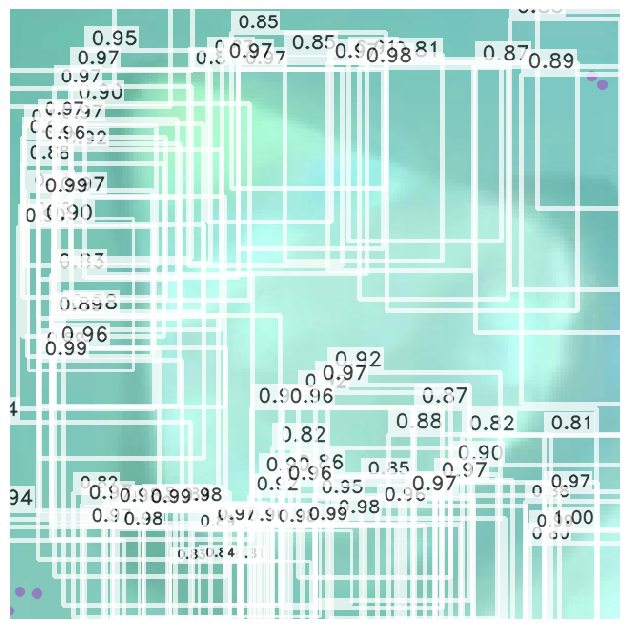

In [36]:
img_url = "//content/zahn_35_png.rf.2136c582e63376eca94e4349cdd2916d.jpg"
best_model.predict(img_url, conf=0.8).show()

In [39]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!cp -r "/content/checkpoints/first_yn_pose_run/RUN_20240409_123803_683812" "/content/drive/MyDrive/Colab Notebooks"